In [2]:
import os
from glob import glob
import random
import time
import tensorflow
import datetime
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 3 = INFO, WARNING, and ERROR messages are not printed

from tqdm import tqdm

import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       
from tensorflow.keras import utils 
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16





## Import the Datasets

I'll import the `.csv` file to read the labels.

In [26]:
dataset = pd.read_csv('driver_imgs_list.csv')
dataset

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg
...,...,...,...
22419,p081,c9,img_56936.jpg
22420,p081,c9,img_46218.jpg
22421,p081,c9,img_25946.jpg
22422,p081,c9,img_67850.jpg


From the csv file, I'll use the `classname` as the labels for the images and use the image names to match the labels with the correct images.

#### Import Driver Dataset

In [4]:
by_drivers = dataset.groupby('subject')
unique_drivers = by_drivers.groups.keys()
print(unique_drivers)

dict_keys(['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081'])


In the following, I prepare the code to import the dataset of the driver images. then populate a few variables.

In [5]:

# Parent directory path
parent_directory = r'D:\Documents\ANN LAB\Assignment\final project\imgs'

# Load the dataset previously downloaded from Kaggle
NUMBER_CLASSES = 10

# Color type: 1 - grey, 3 - rgb

def get_cv2_image(path, img_rows, img_cols, color_type=3):
    # Loading as Grayscale image
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    # Reduce size
    img = cv2.resize(img, (img_rows, img_cols)) 
    return img

# Training
def load_train(img_rows, img_cols, color_type=3):
    start_time = time.time()
    train_images = [] 
    train_labels = []
    # Loop over the training folder 
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('Loading directory c{}'.format(classed))
        directory = os.path.join(parent_directory, 'train', 'c' + str(classed))
        files = [os.path.join(directory, f) for f in os.listdir(directory) if f.lower().endswith('.jpg')]
        for file in files:
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classed)
    print("Data Loaded in {} second".format(time.time() - start_time))
    return train_images, train_labels 

def read_and_normalize_train_data(img_rows, img_cols, color_type):
    X, labels = load_train(img_rows, img_cols, color_type)
    y = utils.to_categorical(labels, 10)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return x_train, x_test, y_train, y_test

# Validation
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    path = os.path.join(parent_directory, 'test', '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)
    
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    
    return test_data, test_ids


In [6]:
img_rows = 64
img_cols = 64
color_type = 1

In [7]:
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)
print('Train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|████████▎                                                                          | 1/10 [00:06<00:58,  6.53s/it]

Loading directory c1


 20%|████████████████▌                                                                  | 2/10 [00:12<00:47,  5.96s/it]

Loading directory c2


 30%|████████████████████████▉                                                          | 3/10 [00:18<00:43,  6.22s/it]

Loading directory c3


 40%|█████████████████████████████████▏                                                 | 4/10 [00:25<00:38,  6.34s/it]

Loading directory c4


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:31<00:31,  6.22s/it]

Loading directory c5


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:37<00:24,  6.22s/it]

Loading directory c6


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:42<00:17,  5.98s/it]

Loading directory c7


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:47<00:11,  5.62s/it]

Loading directory c8


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:52<00:05,  5.40s/it]

Loading directory c9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:58<00:00,  5.83s/it]

Data Loaded in 58.263983488082886 second
Train shape: (17939, 64, 64, 1)
17939 train samples


In [8]:
nb_test_samples = 79726
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)
print('Test shape:', test_files.shape)
print(test_files.shape[0], 'Test samples')

100%|███████████████████████████████████████████████████████████████████████████| 79726/79726 [03:46<00:00, 351.36it/s]


Test shape: (79726, 64, 64, 1)
79726 Test samples


#### Statistics

In [9]:
# Statistics
# Load the list of names
names = [item[17:19] for item in sorted(glob(os.path.join(parent_directory, 'train', '*')))]
test_files_size = len(np.array(glob(os.path.join(parent_directory, 'test', '*.jpg'))))
x_train_size = len(x_train)
categories_size = len(names)
x_test_size = len(x_test)
print('There are %s total images.\n' % (test_files_size + x_train_size + x_test_size))
print('There are %d training images.' % x_train_size)
print('There are %d total training categories.' % categories_size)
print('There are %d validation images.' % x_test_size)
print('There are %d test images.'% test_files_size)


There are 102150 total images.

There are 17939 training images.
There are 10 total training categories.
There are 4485 validation images.
There are 79726 test images.


In [10]:
x_train.shape

(17939, 64, 64, 1)

#### Dataset Visualization

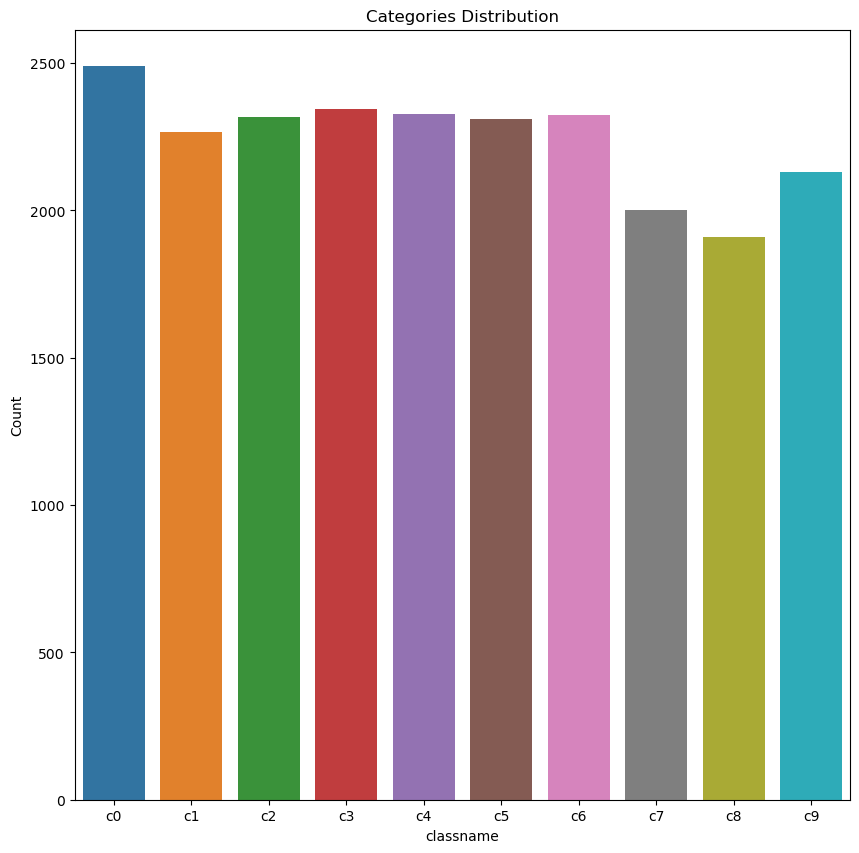

In [11]:
# Plot figure size
plt.figure(figsize = (10,10))
# Count the number of images per category
sns.countplot(x = 'classname', data = dataset)
# Change the Axis names
plt.ylabel('Count')
plt.title('Categories Distribution')
# Show plot
plt.show()

In [12]:
# Find the frequency of images per driver
drivers_id = pd.DataFrame((dataset['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']
drivers_id

,driver_id,Counts
0,p021,1237
1,p022,1233
2,p024,1226
3,p026,1196
4,p016,1078
5,p066,1034
6,p049,1011
7,p051,920
8,p014,876
9,p015,875


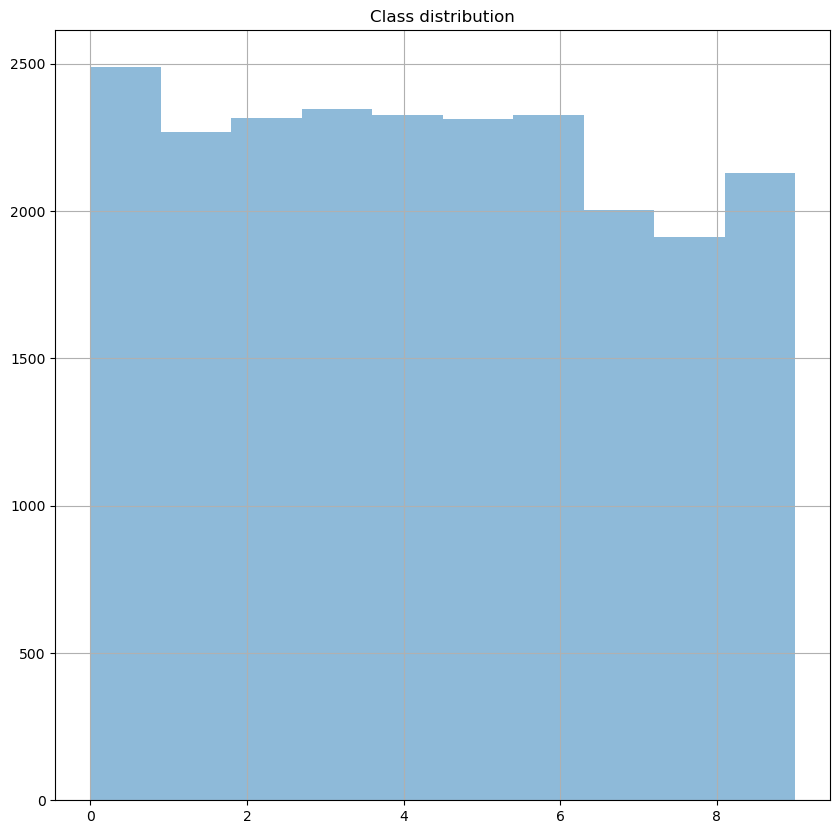

In [13]:
# Plotting class distribution
dataset['class_type'] = dataset['classname'].str.extract('(\d)', expand=False).astype(float)
plt.figure(figsize=(10, 10))
dataset['class_type'].hist(alpha=0.5, bins=10)
plt.title('Class distribution')
plt.show()


#### Images overview

Let's take a look at the various images in the dataset. I'll plot an image for each of the 10 classes. As the directory names are not descriptive, I'll use a map to define the title for each image that is more descriptive.

In [14]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}

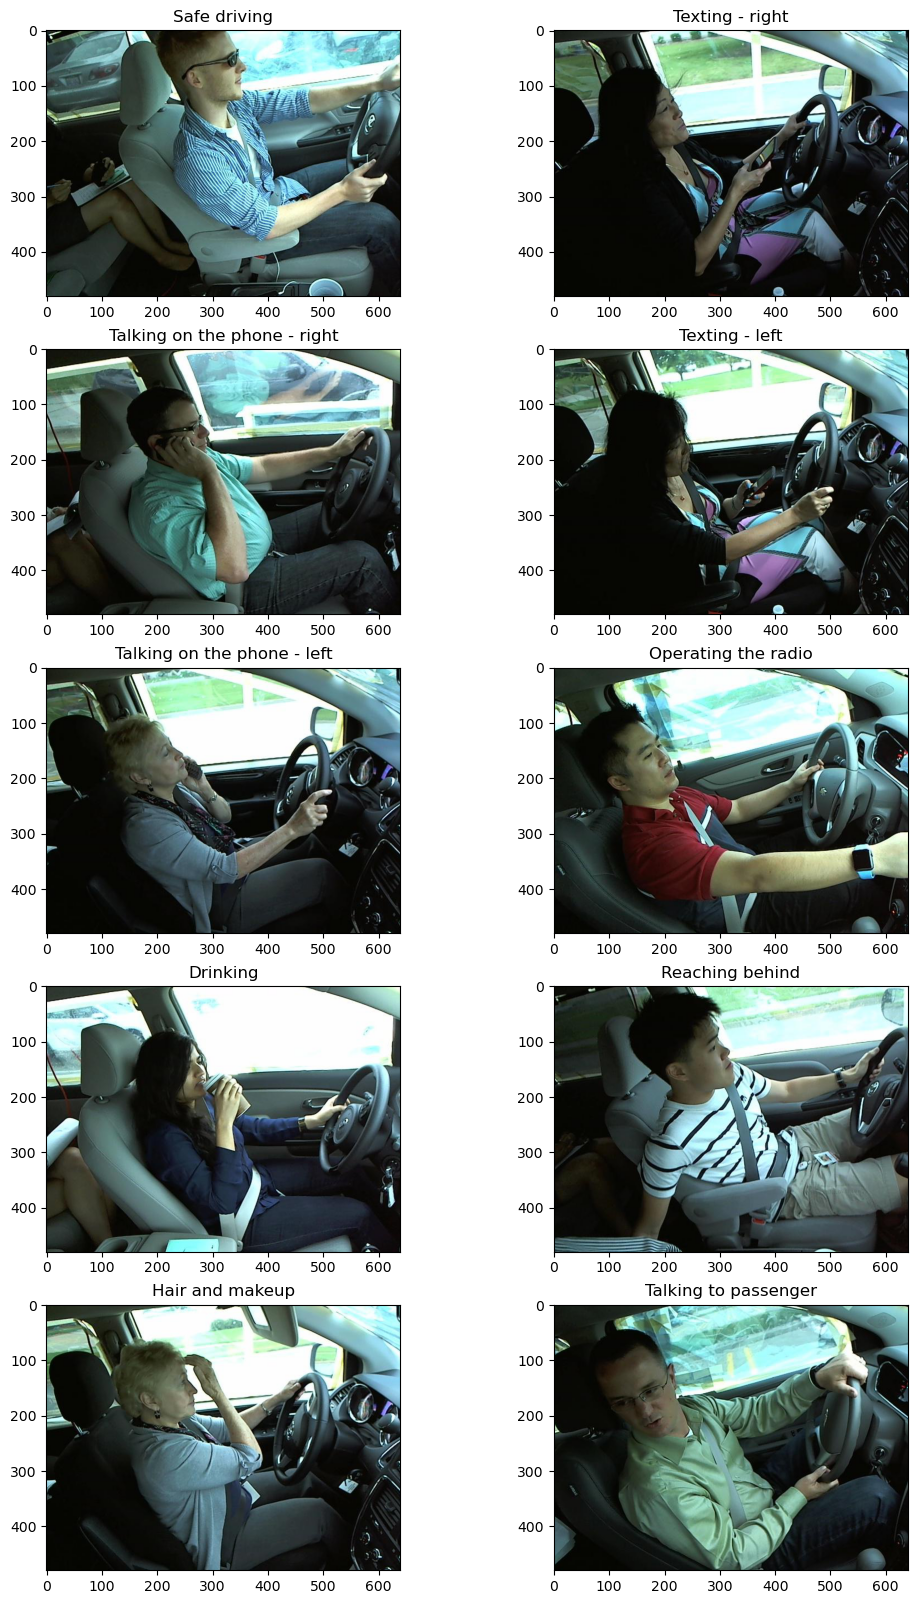

In [15]:
plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = parent_directory + '/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])

In [23]:
def create_submission(predictions, test_id, info):
    result = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
#     result.loc[:, 'img'] = pd.Series(test_id, index=result.index)
    result.insert(0, 'img', test_id)  # 将'img'列插入到第一列位置
    
    now = datetime.datetime.now()
    
    if not os.path.isdir('kaggle_submissions'):
        os.mkdir('kaggle_submissions')

#     suffix = "{}_{}".format(info,str(now.strftime("%Y-%m-%d-%H-%M")))
#     sub_file = os.path.join('kaggle_submissions', 'submission_' + suffix + '.csv')
    sub_file = os.path.join('submission.csv')
    result.to_csv(sub_file, index=False)
    
    return sub_file

## Create a vanilla CNN model

#### Building the model

I'll develop the model with a total of 4 Convolutional layers, then a Flatten layer and then 2 Dense layers. I'll use the optimizer as `rmsprop`, and loss as `categorical_crossentropy`.

In [24]:
batch_size = 40
nb_epoch = 10

In [25]:
import os

# Remove file
if os.path.exists("saved_models/weights_best_vanilla.hdf5"):
    os.remove("saved_models/weights_best_vanilla.hdf5")
else:
    print("model does not exist")

model does not exist


In [26]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
checkpointer = ModelCheckpoint(filepath='saved_models/weights_best_vanilla.keras', 
                               monitor='val_loss', mode='min',
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
callbacks = [checkpointer, es]

#### Model v1
---

In [27]:
def create_model_v1():
    model = Sequential()

    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=(img_rows, img_cols, color_type)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, padding='same', kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=256, padding='same', kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=512, padding='same', kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    return model


In [28]:
model_v1 = create_model_v1()

model_v1.summary()

model_v1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 256)        0

In [29]:
history_v1 = model_v1.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          callbacks=callbacks,
          epochs=nb_epoch, batch_size=batch_size, verbose=1)


Epoch 1/10
449/449 [==============================] - ETA: 0s - loss: 3.5336 - accuracy: 0.4766
Epoch 1: val_loss improved from inf to 0.37260, saving model to saved_models\weights_best_vanilla.keras
449/449 [==============================] - 374s 831ms/step - loss: 3.5336 - accuracy: 0.4766 - val_loss: 0.3726 - val_accuracy: 0.8912
Epoch 2/10
449/449 [==============================] - ETA: 0s - loss: 0.3538 - accuracy: 0.8946
Epoch 2: val_loss improved from 0.37260 to 0.25246, saving model to saved_models\weights_best_vanilla.keras
449/449 [==============================] - 384s 856ms/step - loss: 0.3538 - accuracy: 0.8946 - val_loss: 0.2525 - val_accuracy: 0.9340
Epoch 3/10
449/449 [==============================] - ETA: 0s - loss: 0.2260 - accuracy: 0.9396
Epoch 3: val_loss improved from 0.25246 to 0.13641, saving model to saved_models\weights_best_vanilla.keras
449/449 [==============================] - 369s 823ms/step - loss: 0.2260 - accuracy: 0.9396 - val_loss: 0.1364 - val_accu

Load the classifier with the best validation loss

In [30]:
model_v1.load_weights('saved_models/weights_best_vanilla.keras')

In [51]:
def plot_train_history(history):
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

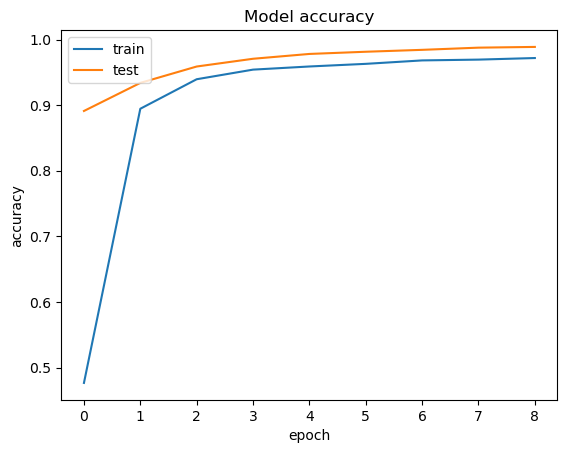

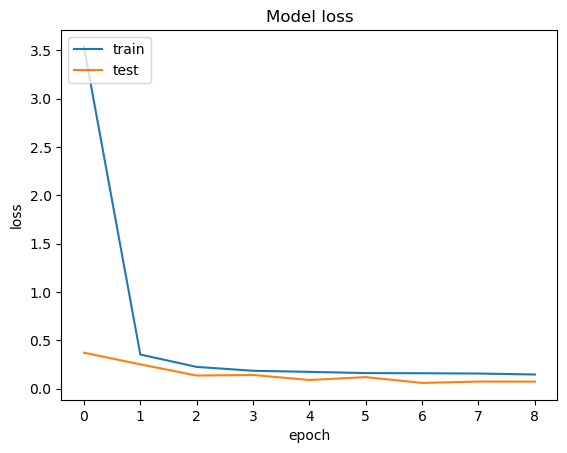

In [52]:
plot_train_history(history_v1)

In [82]:
def plot_test_class(model, test_files, image_number, color_type=1):
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute, (img_rows, img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1, img_rows, img_cols, color_type)

    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(activity_map.get('c{}'.format(np.argmax(y_prediction)))))

    plt.show()


In [34]:
score = model_v1.evaluate(x_test, y_test, verbose=1)
print('Score: ', score)

141/141 [==============================] - 18s 128ms/step - loss: 0.0603 - accuracy: 0.9844
Score:  [0.06026593595743179, 0.9843924045562744]


1/1 [==============================] - 0s 25ms/step
Y prediction: [[5.8743386e-05 1.4856862e-05 9.4454211e-01 5.1951796e-02 2.8869460e-04
  1.3290067e-03 1.2758008e-03 4.2907000e-04 8.2029663e-05 2.7802898e-05]]
Predicted: Talking on the phone - right


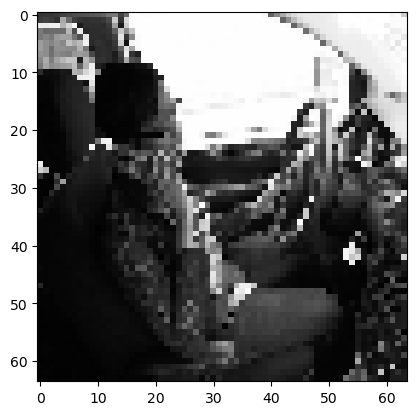

In [81]:
plot_test_class(model_v1, test_files, 18)

In [45]:
import ipywidgets as widgets
from IPython.display import display

# Function to display the predicted class for a selected test image
def on_image_selected(change):
    with output:
        output.clear_output()
        plot_test_class(model_v1, test_files, change['new'], color_type)

# Image selector slider
image_selector = widgets.IntSlider(
    value=0, min=0, max=len(test_files)-1, step=1, description='Image:', continuous_update=False
)
image_selector.observe(on_image_selected, names='value')

# Display the slider
display(image_selector)

# Output widget for displaying the plot
output = widgets.Output()
display(output)

# Initial plot
with output:
    plot_test_class(model_v1, test_files, 0, color_type)


IntSlider(value=0, continuous_update=False, description='Image:', max=79725)

Output()

In [44]:
import pickle
from tensorflow.keras.models import load_model

# Save the model
model_v1.save('model_v1.h5')

# Save preprocessing information
preprocessing = {
    'img_rows': img_rows,
    'img_cols': img_cols,
    'color_type': color_type,
    'activity_map': activity_map
}

with open('preprocessing.pkl', 'wb') as f:
    pickle.dump(preprocessing, f)


1/1 [==============================] - 0s 24ms/step


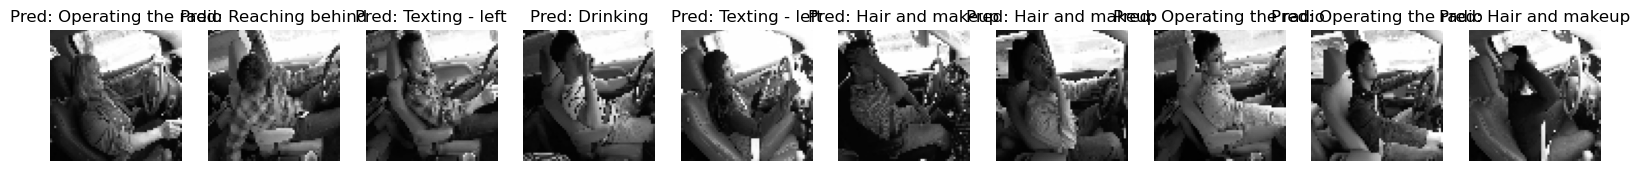

In [79]:
# Function to plot and predict multiple test images
def plot_multiple_test_images(model, test_files, img_rows, img_cols, color_type=1, num_images=10):
    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        img = test_files[i]
        img = cv2.resize(img, (img_rows, img_cols))
        plt.imshow(img, cmap='gray')
        img = img.reshape(-1, img_rows, img_cols, color_type)
        prediction = model.predict(img)
        predicted_class = np.argmax(prediction)
        predicted_label = activity_map['c' + str(predicted_class)]
        plt.title(f'Pred: {predicted_label}')
        plt.axis('off')
    plt.show()

# Test multiple images
plot_multiple_test_images(model_v1, x_test, img_rows, img_cols, color_type, num_images=10)


141/141 [==============================] - 19s 132ms/step
                              precision    recall  f1-score   support

                Safe driving       1.00      0.95      0.98       463
             Texting - right       0.99      0.99      0.99       500
Talking on the phone - right       0.99      0.99      0.99       480
              Texting - left       0.99      1.00      0.99       491
 Talking on the phone - left       1.00      0.99      1.00       466
         Operating the radio       1.00      0.99      0.99       466
                    Drinking       0.97      1.00      0.98       457
             Reaching behind       1.00      0.99      0.99       377
             Hair and makeup       0.97      0.97      0.97       390
        Talking to passenger       0.94      0.98      0.96       395

                    accuracy                           0.98      4485
                   macro avg       0.98      0.98      0.98      4485
                weighted avg  

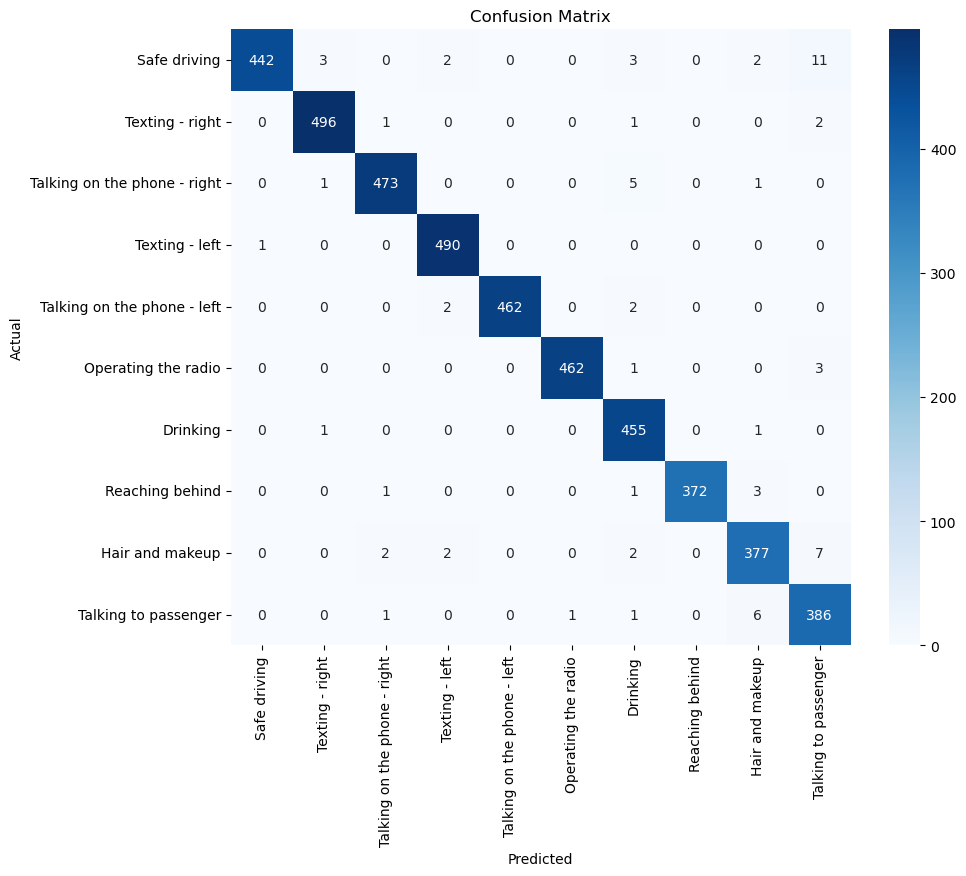

In [54]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model on the test set
y_pred = model_v1.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=[activity_map[f'c{i}'] for i in range(NUMBER_CLASSES)]))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[activity_map[f'c{i}'] for i in range(NUMBER_CLASSES)], yticklabels=[activity_map[f'c{i}'] for i in range(NUMBER_CLASSES)])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
